<a href="https://colab.research.google.com/github/lkarjun/reverse-image-search/blob/main/rimg_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [ ]:
!pip install fastai -Uqq

In [1]:
from fastai.vision.all import *
from torch.optim import AdamW
from tqdm import tqdm

## Download dataset

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "lkarjun"
os.environ['KAGGLE_KEY'] = "96d0e367426087ce8a91876ea3de5244"

In [ ]:
!kaggle datasets download -d duttadebadri/image-classification
!unzip image-classification.zip

In [2]:
dataset_path = Path("/content/images/images")

## Here we go

### Dataloader

In [3]:
def get_fnames(dataset_path, folders: list, n_files = 300):
  fnames = []
  full_fnames = []
  for folder in folders:
    files = get_image_files(dataset_path/folder)
    full_fnames += files
    fnames += files[:n_files]
  return fnames, full_fnames

In [4]:
fnames, full_fnames = get_fnames(dataset_path, ['architecure', 'art and culture'])

In [5]:
BATCH_SIZE = 64
RESIZE = 224

def get_dls(fnames):
  dls = ImageDataLoaders.from_path_func(
                dataset_path, 
                fnames, 
                parent_label,
                batch_tfms = Normalize.from_stats(*imagenet_stats), 
                item_tfms = Resize(RESIZE), 
                bs=BATCH_SIZE
              )
  return dls

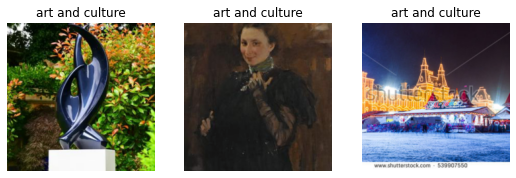

In [6]:
dls = get_dls(fnames)

dls.show_batch(max_n = 3)

In [7]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

### Model

In [8]:
body = create_body(resnet34, cut=-2)

In [9]:
head = create_head(nf = num_features_model(body), 
                   lin_ftrs=[512, 128],
                   n_out = 2, 
                   concat_pool=False, 
                   pool=True)
head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=512, out_features=128, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=False)
)

In [10]:
class RImgModel(Module):
    def __init__(self, body,head):
        self.body = body
        self.head = head
    
    def forward(self, x):
        x = self.body(x)
        return self.head(x)

In [11]:
model = RImgModel(body, head).cuda()

In [12]:
def model_splitter(model):
    return L(model.body, model.head).map(params)

In [13]:
learn = Learner(dls, model,
                splitter = model_splitter, 
                metrics=accuracy)

In [14]:
learn.summary()

RImgModel (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                       

In [15]:
learn.freeze()

In [16]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.519255,0.300256,0.933333,00:07
1,0.281202,0.046499,0.983333,00:06
2,0.182887,0.019753,1.000000,00:06
3,0.133347,0.017907,1.000000,00:06


In [17]:
# lower lr for body and high for head
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.020386,0.017776,1.000000,00:07
1,0.016230,0.016143,1.000000,00:08
2,0.014711,0.016099,1.000000,00:07
3,0.016045,0.015425,1.000000,00:07


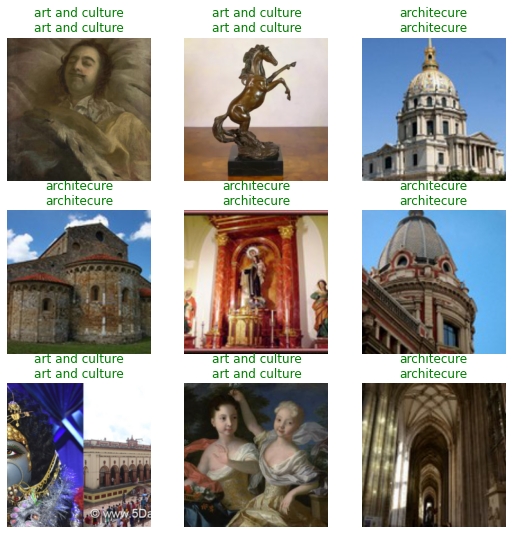

In [18]:
learn.show_results()

### Geting feature vector

In [19]:
model.head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=512, out_features=128, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=False)
)

In [20]:
def get_feature_vector(learn, X = None, dl = None, batch = False):
  with hook_output(learn.model.head[8]) as h:
    if batch:
      y = learn.get_preds(dl=dl)
    else:
      y = learn.predict(X)
  return h.stored

In [27]:
def process_batch(fnames, learn):
  features = []
  dl = learn.dls.test_dl(fnames)
  for i in tqdm(range(0, len(fnames), BATCH_SIZE)):
      names = fnames[i:i + BATCH_SIZE]
      dl = learn.dls.test_dl(names)
      features += get_feature_vector(dl = dl, batch = True, learn = learn)

  features = torch.stack(features, dim = 0).cpu().numpy()
  return features

In [28]:
features = process_batch(fnames, learn)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:06,  1.37it/s]

 20%|██        | 2/10 [00:01<00:05,  1.51it/s]

 30%|███       | 3/10 [00:01<00:04,  1.69it/s]

 40%|████      | 4/10 [00:02<00:03,  1.88it/s]

 50%|█████     | 5/10 [00:03<00:03,  1.61it/s]

 60%|██████    | 6/10 [00:04<00:03,  1.04it/s]

 70%|███████   | 7/10 [00:06<00:03,  1.23s/it]

 80%|████████  | 8/10 [00:07<00:02,  1.25s/it]

 90%|█████████ | 9/10 [00:09<00:01,  1.39s/it]

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


In [29]:
features.shape

(600, 128)

### Similar Images

In [59]:
from sklearn.neighbors import NearestNeighbors

def get_neighbor(features):
  neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute',metric='cosine')
  return neighbors.fit(features)

In [60]:
neighbors = get_neighbor(features)

In [69]:
def plot_similar_images(test_idx, features, fnames):
  distances, indices = neighbors.kneighbors([features[test_idx]])
  plt.imshow(Image.open(fnames[test_idx]))
  plt.title("Image")

  fig, axs = plt.subplots(2,5, figsize=(15, 10))

  for ax, idx, dis in zip(axs.flatten(), indices.flatten(), distances.flatten()):
    img = Image.open(fnames[idx])
    ax.imshow(img)
    ax.set_title(dis)

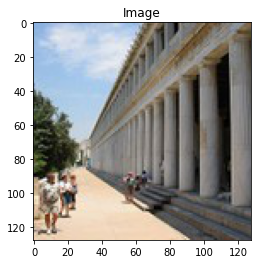

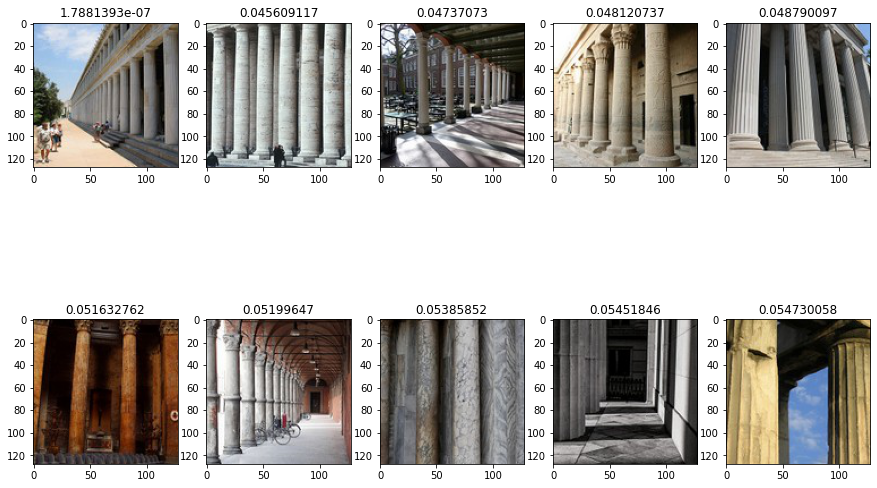

In [64]:
plot_similar_images(53, features, fnames)

### Retrain When New Cate Added

In [49]:
def get_new_learner(old_learner, dls, lin_ftrs = [512, 128]):
  body = old_learner.model.body
  head = create_head(nf = num_features_model(body), 
                   lin_ftrs=lin_ftrs,
                   n_out = dls.c, 
                   concat_pool=False, 
                   pool=True)
  
  model = RImgModel(body, head).cuda()
  learn = Learner(dls, model,
                  splitter = model_splitter, 
                  metrics=[accuracy, error_rate])
  learn.freeze()
  return learn



In [50]:
fnames, full_fnames = get_fnames(dataset_path, ['architecure', 'art and culture', 'travel and  adventure'], 300)

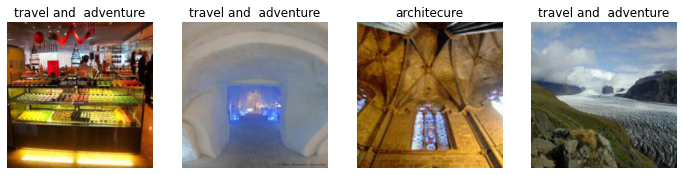

In [52]:
dls = get_dls(fnames)

dls.show_batch(max_n = 4, nrows = 1)

In [53]:
new_learner = get_new_learner(learn, dls)

In [54]:
new_learner.summary()

RImgModel (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

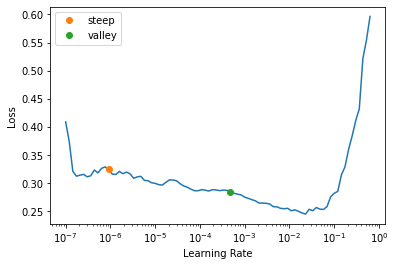

In [214]:
lr_values = new_learner.lr_find(suggest_funcs=[steep, valley])

In [55]:
new_learner.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.783969,0.441658,0.872222,0.127778,00:09
1,0.473681,0.202883,0.922222,0.077778,00:08
2,0.321533,0.171330,0.944444,0.055556,00:09
3,0.245601,0.153899,0.944444,0.055556,00:08


In [56]:
# lower lr for body and high for head
new_learner.unfreeze()
new_learner.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.066737,0.151322,0.944444,0.055556,00:08
1,0.075019,0.146382,0.944444,0.055556,00:08
2,0.066683,0.146240,0.944444,0.055556,00:10
3,0.067787,0.144760,0.950000,0.050000,00:08


In [66]:
new_features = process_batch(fnames, new_learner)

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:00<00:09,  1.48it/s]

 13%|█▎        | 2/15 [00:01<00:08,  1.47it/s]

 20%|██        | 3/15 [00:01<00:06,  1.73it/s]

 27%|██▋       | 4/15 [00:02<00:05,  1.89it/s]

 33%|███▎      | 5/15 [00:03<00:06,  1.59it/s]

 40%|████      | 6/15 [00:04<00:08,  1.04it/s]

 47%|████▋     | 7/15 [00:06<00:09,  1.24s/it]

 53%|█████▎    | 8/15 [00:07<00:08,  1.26s/it]

 60%|██████    | 9/15 [00:09<00:08,  1.34s/it]

 67%|██████▋   | 10/15 [00:10<00:06,  1.35s/it]

 73%|███████▎  | 11/15 [00:11<00:04,  1.10s/it]

 80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

 87%|████████▋ | 13/15 [00:12<00:01,  1.26it/s]

 93%|█████████▎| 14/15 [00:12<00:00,  1.41it/s]

100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


In [68]:
neighbors = get_neighbor(new_features)

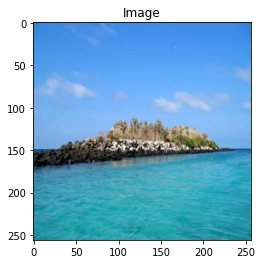

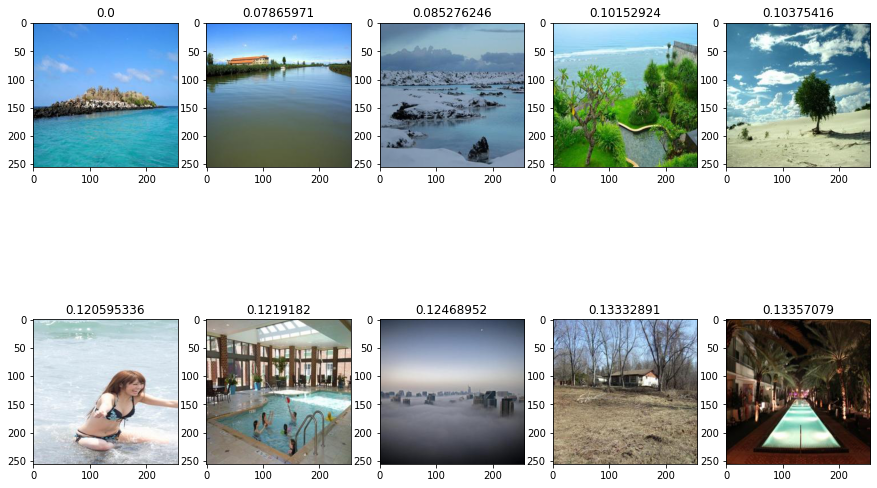

In [75]:
plot_similar_images(750, new_features, fnames)

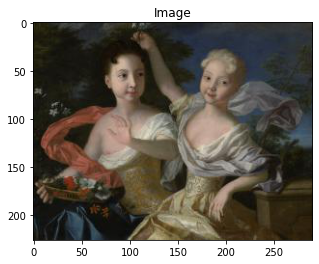

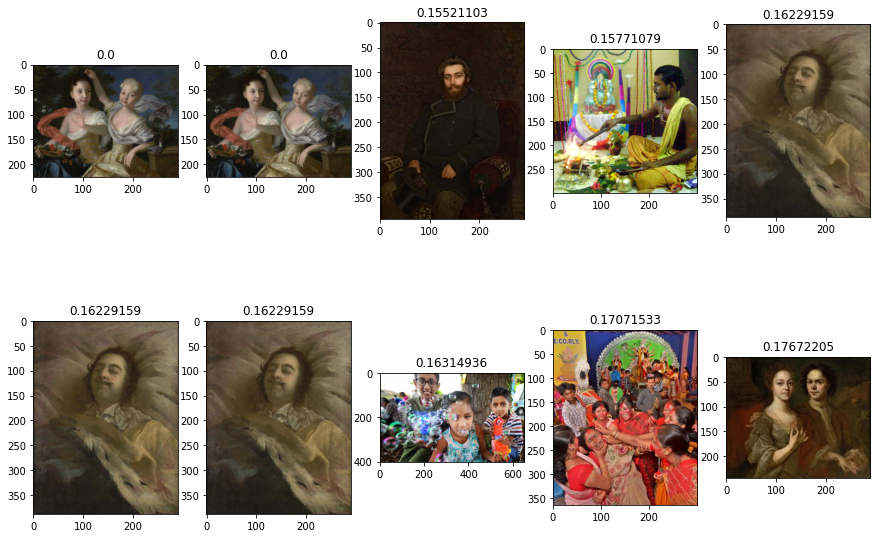

In [77]:
plot_similar_images(400, new_features, fnames)

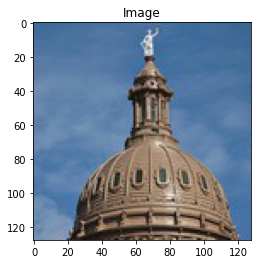

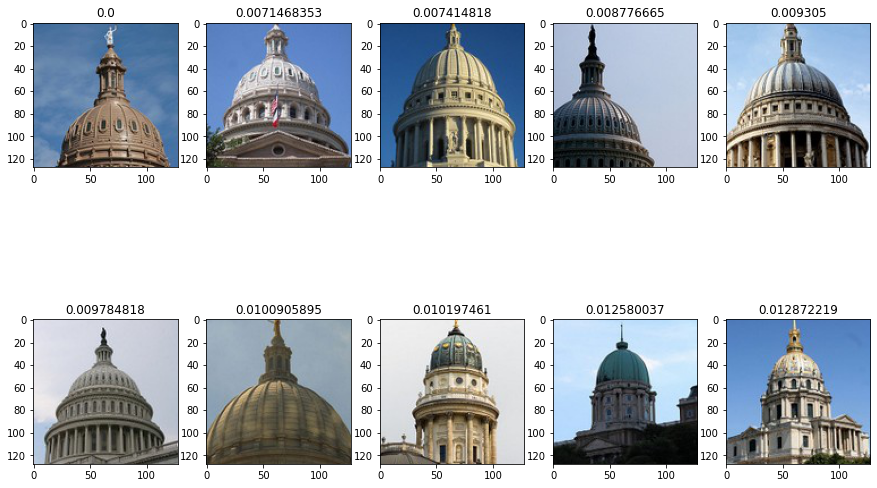

In [78]:
plot_similar_images(200, new_features, fnames)